## License

This notebook is a conversion of a Sentinel Hub evalscript and is licensed under
**CC-BY-SA-4.0**.

Original evalscript: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/hollstein/  
Source: Sentinel Hub Custom Scripts (CC-BY-SA-4.0)  
Conversion: Development Seed (openEO-UDP project)


# Hollstein Cloud Classification

Cloud, cirrus, and shadow detection is among the early processing steps in remote sensing that enables many downstream applications. Robust classification of these features, along with snow and water, is essential for atmospheric correction, surface reflectance retrieval, and image co-registration. 

This notebook demonstrates how to detect clouds, cirrus, snow, shadows, and clear sky using the decision tree algorithm explained in [Hollstein et al., (2016)](https://www.mdpi.com/2072-4292/8/8/666#). The algorithm is applied to top-of-atmosphere reflectance spectra from Sentinel-2 L1C imagery.

Sentinel-2 MSI offers optimized bands for Earth observation applications, including the detection of visible and sub-visible cirrus clouds, the cirrus channel (B10), which is essential in the decision tree algorithm introduced in this notebook.

The algorithm was originally implemented as a Sentinel Hub Evalscript and has now been translated to openEO processes to enable its deployment across different remote computing resources.

Pros:


Cons:
- Limited classification skill (?)

## Overview

In this notebook, we will:
1. Define an area of interest that might contain clouds
2. Connect to an CDSE backend service
3. Load Sentinel-2-L1C imagery for a specific date
4. Classify the spectral bands in decision tree algorithm; cirrus clouds using B10, distinguish water from clear sky and shadows by evaluating the power of B09, and distinguish snow from clouds using B11. Run the classification in CDSE backend


## Import Required Libraries

We begin by importing the necessary Python libraries for data processing and visualization.

In [29]:
import openeo
import matplotlib.pyplot as plt
from PIL import Image
from openeo.processes import subtract, divide, array_create, if_

## Define Area of Interest

Define the spatial extent for our analysis. This example uses coordinates for an area in Croatia

In [30]:
spatial_extent = {"west" : 12.3793, "south" : 45.8996, "east" : 12.7918, "north" : 46.1364}

## Executing the Cloud Detection Algorithm in CDSE Backend

Connect to the OpenEO backend and authenticate using OpenID Connect. This section demonstrates executions using Sentinel-2 L1C data, including Band 10 (SWIR-Cirrus, 1373.5 nm)

In [31]:
connection = openeo.connect(
    url="https://openeo.dataspace.copernicus.eu/"
).authenticate_oidc()

Authenticated using refresh token.


## Load Sentinel-2 L1C Data 

Load Sentinel-2 L1C (top-of-atmosphere reflectance) data. We need multiple bands for cloud detection:
- **B01**: Coastal aerosol, 442.7 nm
- **B02**: Blue, 492.4 nm
- **B03**: Green, 559.8 nm
- **B04**: Red, 664.6 nm
- **B05**: Vegetation red edge, 704.1 nm
- **B06**: Vegetation red edge, 740.5 nm
- **B07**: Vegetation red edge, 782.8 nm
- **B8A**: Narrow NIR, 864.7 nm
- **B09**: Water vapour, 945.1 nm, used to distinguish clear sky, water, and shadows
- **B10**: SWIR – Cirrus, 1373.5 nm, used to distinguish cirrus clouds
- **B11**: SWIR, 1613.7 nm, used to distinguish snow from clouds

In [32]:
s2cube = connection.load_collection(
    "SENTINEL2_L1C",
    spatial_extent=spatial_extent,
    temporal_extent=["2025-05-12", "2025-05-13"], # 
    bands=[
        "B01",
        "B02",
        "B03",
        "B04",
        "B05",
        "B06",
        "B07",
        "B8A",
        "B09",
        "B10",
        "B11"
    ],
)

s2cube = s2cube.reduce_dimension(dimension="t", reducer="first")

## Decision Tree for Cloud Detection
![Decision tree for Hollstein algorithm to detect normal clouds, cirrus clouds, and snow](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/hollstein/fig/tree.png)

Where:
- B = band
- S = subtraction / difference
- R = ratio

In [33]:
def cloud_detection_algorithm(data):
    B01, B02, B03, B04, B05, B06, B07, B8A, B09, B10, B11 = (
        data[0],
        data[1],
        data[2],
        data[3],
        data[4],
        data[5],
        data[6],
        data[7],
        data[8],
        data[9],
        data[10]
    )

    B01 = B01 / 10000
    B02 = B02 / 10000
    B03 = B03 / 10000
    B04 = B04 / 10000
    B05 = B05 / 10000
    B06 = B06 / 10000
    B07 = B07 / 10000
    B8A = B8A / 10000
    B09 = B09 / 10000
    B10 = B10 / 10000
    B11 = B11 / 10000

    gain = 2.5

    # Define color mapping
    clear = array_create([B04 * gain, B03 * gain, B02 * gain])
    shadow = array_create([B04 * gain, B03 * gain, B02 * gain])

    water = array_create([0.1, 0.1, 0.7])
    cirrus = array_create([0.8, 0.1, 0.1])  # Red
    cloud = array_create([0.3, 0.3, 1.0])  # Blue
    snow = array_create([1.0, 0.8, 0.4])

    # Decision tree
    result = if_(
        B03 < 0.319,
        if_(
            B8A < 0.166,
            if_(
                (subtract(B03, B07)) < 0.027,
                if_((subtract(B09, B11)) < -0.097, clear, shadow),
                if_((subtract(B09, B11)) < 0.021, water, shadow),
            ),
            if_(
                (divide(B02, B10)) < 14.689,
                if_((divide(B02, B09)) < 0.788, clear, cirrus),
                clear,
            ),
        ),
        if_(
            (divide(B05, B11)) < 4.330,
            if_(
                (subtract(B11, B10)) < 0.255,
                if_((subtract(B06, B07)) < -0.016, cloud, cirrus),
                if_(B01 < 0.300, clear, cloud),
            ),
            if_(B03 < 0.525, if_((divide(B01, B05)) < 1.184, clear, shadow), snow),
        ),
    )

    return result

In [34]:
hollstein_cloud = s2cube.apply_dimension(
    dimension="bands",
    process=cloud_detection_algorithm
)

hollstein_cloud = hollstein_cloud.linear_scale_range(input_min=0, input_max=1, output_min=0, output_max=255)

hollstein_cloud = hollstein_cloud.save_result("PNG")

In [35]:
# Send job to backend and download the result
hollstein_cloud.download("hollstein_cloud.png")

## Visualize the Result From CDSE Backend

The image is generated in the CDSE backend with the following requirements:
- **Data scaling**: CDSE stores values in integer values (0-10000), which needs to be scaled to reflectance values (0-1)
- **Band 10 usage**: B10 from Sentinel-2 L1C (top-of-atmosphere imager) is essential for distinguishing cirrus clouds from other cloud types. Omitting B10 leads to underestimation of cirrus cloud presence
- **Array broadcasting**: The algorithm does not require broadcasting identical x,y dimensions when creating color arrays for water, cirrus, clouds, and snow classifications
- **Processing time and limitations**: Job execution takes approx. 2 minutes for small area coverage. Larger area may cause:
   - Geometric distortion due to (possibly) on-the-fly re-projection
   - PNG export failues (returning an error along the line of Array Index Out of Bounds)
   - Solution: Export as `.tif` format instead of PNG when processing large areas

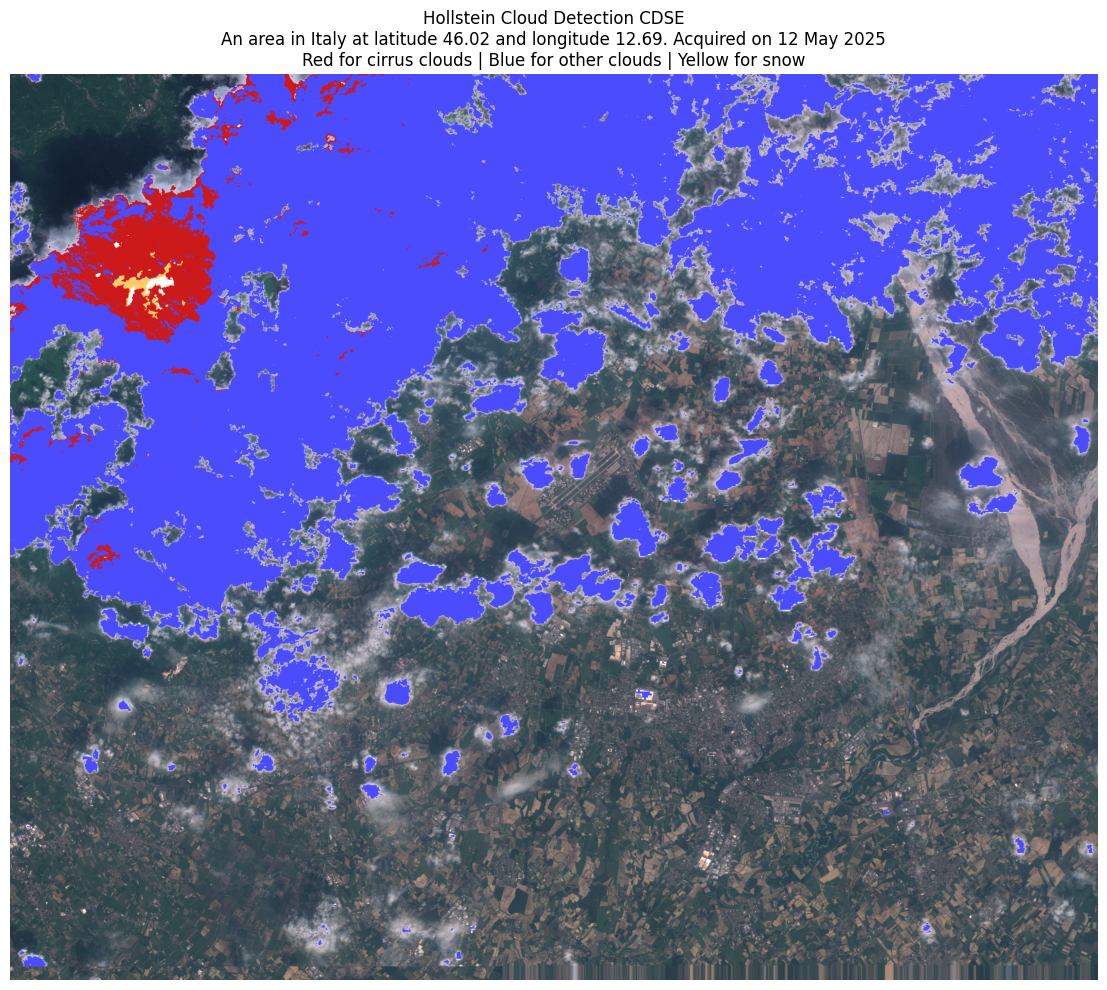

In [36]:
img = Image.open("hollstein_cloud.png")

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
ax.imshow(img)
ax.set_title(
    "Hollstein Cloud Detection CDSE\n"
    "An area in Italy at latitude 46.02 and longitude 12.69. Acquired on 12 May 2025\n"
    "Red for cirrus clouds | Blue for other clouds | Yellow for snow",
    fontsize=12,
)
ax.axis("off")
plt.tight_layout()
plt.show()

## Interpretation Guide

### Cloud Value Guide
| Color | Classification | 
|-------|-------------------|
| Red | Cirrus clouds | 
| Blue | Clouds | 
| Yellow | Snow |
| Natural colors (R, G, B) | Shadow or clear sky |

### Applications
- Cloud detection as the first processing step for remote sensing data that enables many downstream applications
- The ease of use and simplicity of the decision tree can be served as a baseline algorithm to judge the performance of other, possibly more complex and computationally more demanding, algorithms.

## Method Overview
- The algorithm shows excellent performance concerning classification skill and processing performance, resulting in 91% of correctly classified spectra within a validation dataset.
- While the decision tree achieve 91% accuracy, the author considers the classification skill is limited. When ompared with other sophisticated methods, the accuracy of the decision tree is the lowest
    - Classical Bayesian method: 98% accuracy
    - Random forests and Support Vector Machines (SVM): 98% accuracy
- The 7% accuracy gap represents thousands of misclassified pixels in satellite imagery, which may propagate biases in calculating indices
- Decision trees use hard thresholds (e.g. if B03 < 0.319, ..., else ...) which may not be able to capture gradual and complex transitions between classes
- Decision trees lack of probabilistic reasoning as it provides yes/no answer

## Citation
Hollstein, A., Segl, K., Guanter, L., Brell, M., & Enesco, M. (2016). Ready-to-Use Methods for the Detection of Clouds, Cirrus, Snow, Shadow, Water and Clear Sky Pixels in Sentinel-2 MSI Images. *Remote Sensing*, 8(8), 666. https://doi.org/10.3390/rs8080666

## Attribution

This openEO User-Defined Process is a conversion of the original Sentinel Hub evalscript:

**Original Script:** [Cloud Classification Script](https://custom-scripts.sentinel-hub.com/sentinel-2/hollstein/)

**Author:** [Not listed in the Sentinel Hub Custom Scripts]

**Source Repository:** [Sentinel Hub Custom Scripts](https://github.com/sentinel-hub/custom-scripts)

This conversion maintains the scientific methodology and visualization approach of the original evalscript while adapting it to the openEO process graph framework for interoperability across openEO-compliant backends.